<a href="https://colab.research.google.com/github/jojordan3/dad-joke-ai/blob/master/pytorch_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gputil
!pip install spacy-pytorch-transformers[cuda100]
!python -m spacy download en_pytt_robertabase_lg

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=3191b17a5642ad2df8f34e0222601483961f003eb7dd18d86d658fcc2b1681d9
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
     |████████████████████████████████| 71kB 3.5MB/s 
     |████████████████████████████████| 184kB 9.7MB/s 
     |████████████████████████████████| 61kB 16.3MB/s 
     |████████████████████████████████| 491kB 18.7MB/s 
     |████████████████████████████████| 808kB 34.6MB/s 
     |████████████████████████████████| 655kB 47.1MB/s 
     |████████████████████████████████| 1.0MB 37.6MB/s 
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-cp36-none-any.whl size=7530 sha256=e7d0104c90b567b457bfeb6bc4fcb62bb2193c9292146750db52e452ec5ff971
  Stored in directory: /root/.cache/pip/wheels/06/06/7b/a5f5920bbf4f12a2c927e438fac17d4cd9560f8336b00e9a99
  Created wheel for ftfy: filename=ftfy-5.6-cp36-none-any.wh

RESTART runtime after download

In [0]:
import spacy
import torch
import cupy
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import random
import time
import unicodedata
import GPUtil
import spacy_pytorch_transformers
import en_pytt_robertabase_lg

from spacy_pytorch_transformers import PyTT_Language, PyTT_WordPiecer, PyTT_TokenVectorEncoder, PyTT_TextCategorizer
from spacy_pytorch_transformers.util import cyclic_triangular_rate
from tqdm import tqdm
from spacy.util import minibatch
from numpy.testing import assert_almost_equal
from scipy.spatial import distance
from google.colab import drive
from wasabi import Printer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.compose import make_column_transformer
from datetime import datetime as dt
from datetime import timezone as tz
from collections import defaultdict

In [2]:
drive.mount('/gdrive')
#%cd /gdrive/My\ Drive/data

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
base_path = '/gdrive/My Drive/data/'

In [4]:
is_using_gpu = spacy.prefer_gpu()
def check_gpu(is_using_gpu):
  if is_using_gpu:
    print("Using GPU!")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
    print("GPU Usage")
    GPUtil.showUtilization()

spacy.prefer_gpu()

True

In [0]:
csv_path = base_path + 'data_dadjokes.csv'

dj = pd.read_csv(csv_path, na_values=["[deleted]", None,'N/A', ' ', '[removed]', ''], index_col=None, sep='|')

In [6]:
print(dj.isna().sum())
print(dj[dj.title.isna()].isna().sum())

id                        0
createdUTC                0
parent_createdUTC    159813
author                14419
title                     4
selftext              14913
score                     0
num_comments              0
dtype: int64
id                   0
createdUTC           0
parent_createdUTC    4
author               0
title                4
selftext             4
score                0
num_comments         0
dtype: int64


In [7]:
dj.drop(index = dj.index[dj.title.isna()], inplace=True)

dj.isna().sum()

id                        0
createdUTC                0
parent_createdUTC    159809
author                14419
title                     0
selftext              14909
score                     0
num_comments              0
dtype: int64

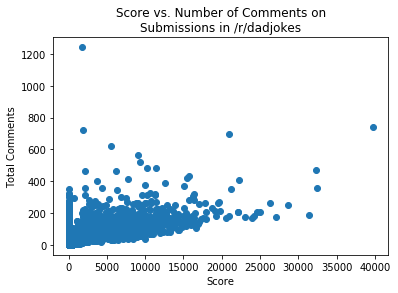

In [8]:
plt.scatter(dj.score, dj.num_comments);
plt.xlabel('Score')
plt.ylabel('Total Comments')
plt.title('Score vs. Number of Comments on\nSubmissions in /r/dadjokes')
plt.show()

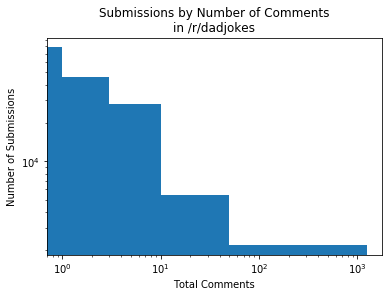

In [10]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Comments')
plt.ylabel('Number of Submissions')
plt.title('Submissions by Number of Comments\nin /r/dadjokes')
plt.hist(dj.num_comments, bins=[0,1,3,10,50,dj.num_comments.max()]);
plt.show()

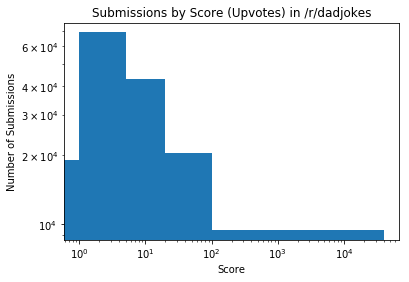

In [11]:
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Score')
plt.ylabel('Number of Submissions')
plt.title('Submissions by Score (Upvotes) in /r/dadjokes')
plt.hist(dj.score, bins=[0,1,5,20,100,dj.score.max()]);
plt.show()

In [9]:
dj['is_crosspost'] = ~dj['parent_createdUTC'].isna()
dj.groupby(by='is_crosspost').mean()    

,createdUTC,parent_createdUTC,score,num_comments
is_crosspost,,,,
False,1.494574e+09,NaN,91.876991,3.318086
True,1.544514e+09,1.543970e+09,2.560386,0.357488


##### Crossposts receive significantly lower scores, num_comments than original posts in the dadjokes subreddit. This may be because viewers are easily redirected to the parent post to comments or upvote in other areas of reddit. However, the contents of the crossposted jokes (title and selftext) are pulled from the parent posts. Therefore crossposts will be analyzed separately when attempting to predict scores, num_comments.

In [10]:
main_dj = dj[~dj.is_crosspost].drop(columns=['parent_createdUTC', 'is_crosspost'])
print(main_dj.shape)

(159809, 7)


In [11]:
train_dj, test_dj = train_test_split(main_dj, test_size=0.2)
print(f"Training sample size: {len(train_dj)}\nTesting sample size: {len(test_dj)}")

train_dj.reset_index(drop=True, inplace=True)
test_dj.reset_index(drop=True, inplace=True)

Training sample size: 127847
Testing sample size: 31962


In [0]:
score_cats = [1, 5, 20, 100]
comment_cats = [1, 3, 10, 50]
newlines = re.compile(r'(\\n)|\s+]')

def _gettext(s):
  if isinstance(s, str):
    s = s.replace('&amp;#x200B;', '')
    s = s.replace('&amp;', 'and')
    s = newlines.sub(' ', s)
  return s


def prepare_text(data):
    data['title_clean'] = data.title.apply(_gettext)
    data['selftext_clean'] = data.selftext.apply(_gettext)
    data['score_cat'] = data.score.apply(lambda _: _categorize(_, score_cats))
    data['comment_cat'] = data.num_comments.apply(
        lambda _: _categorize(_, comment_cats))
    data['createdUTC'] = data.createdUTC.apply(
        lambda x: dt.fromtimestamp(x, tz.utc))
    return data


def _categorize(val, cutoffs):
    for level, upper_bound in enumerate(cutoffs):
        if val < upper_bound:
            return level + 1
    return len(cutoffs) + 1

In [13]:
train_dj = prepare_text(train_dj)
test_dj = prepare_text(test_dj)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [0]:
train_dj.to_csv(base_path + 'train_dj.csv')
test_dj.to_csv(base_path + 'test_dj.csv')

In [0]:
nlp = en_pytt_robertabase_lg.load(torchscript=True)

In [0]:
textcat = nlp.create_pipe("pytt_textcat", config={"exclusive_classes": True,
                                                  'architecture': 'softmax_pooler_output',
                                                  "words_per_batch": 1000})
for label in range(1,6):
    textcat.add_label(label)
nlp.add_pipe(textcat, last=True)

In [7]:
def check_pipe_config(nlp):
  for p in nlp.pipe_names:
    print(repr(p))
    try:
      print(nlp.get_pipe(p).cfg)
    except:
      pass
    try:
      print('model component included?:', nlp.get_pipe(p).model, '\n')
    except:
      pass

check_pipe_config(nlp)

'sentencizer'
'pytt_wordpiecer'
{'deprecation_fixes': {'vectors_name': None}, 'pytt_name': 'roberta-base'}
model component included?: <spacy_pytorch_transformers._tokenizers.SerializableRobertaTokenizer object at 0x7f254594b630> 

'pytt_tok2vec'
{'deprecation_fixes': {'vectors_name': None}, 'pytt_name': 'roberta-base', 'pytt_config': {'finetuning_task': None, 'num_labels': 2, 'output_attentions': True, 'output_hidden_states': True, 'torchscript': False, 'vocab_size': 50265, 'hidden_size': 768, 'num_hidden_layers': 12, 'num_attention_heads': 12, 'hidden_act': 'gelu', 'intermediate_size': 3072, 'hidden_dropout_prob': 0.1, 'attention_probs_dropout_prob': 0.1, 'max_position_embeddings': 514, 'type_vocab_size': 1, 'initializer_range': 0.02, 'layer_norm_eps': 1e-12, 'vocab_size_or_config_json_file': 50265}}
model component included?: <thinc.neural._classes.function_layer.FunctionLayer object at 0x7f2543383358> 

'pytt_textcat'
{'exclusive_classes': True, 'architecture': 'softmax_pooler_outpu

In [0]:
train_dj = pd.read_csv(base_path + 'train_dj.csv')

In [0]:
def complete_joke(title, selftext):
  if isinstance(selftext, str):
    return ' '.join([title, selftext])
  else:
    return title

train_texts = train_dj.apply(
    lambda row: complete_joke(row['title_clean'], row['selftext_clean']), axis=1)
#test_texts = test_dj.apply(
#    lambda row: complete_joke(row['title_clean'], row['selftext_clean']), axis=1)

TRAIN_DATA = list(zip(train_texts, [{"cats": {i: float(val==i) for i in range(1, 6)}} for val in train_dj['score_cat']]))
#TEST_DATA = list(zip(test_texts, [{"cats": {i: float(val==i) for i in range(1, 6)}} for val in test_dj['score_cat']]))

In [0]:
with open(base_path + 'TRAIN.txt', 'w') as train:
  for line in TRAIN_DATA:
    train.write(str(line) + '\n')
with open(base_path + 'TEST.txt', 'w') as test:
  for line in TEST_DATA:
    test.write(str(line) + '\n')

In [11]:
check_gpu(is_using_gpu)

Using GPU!
GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 12% |


doc = nlp(train_texts[0], disable=['pytt_textcat'])
print(doc)
print([sent.text for sent in doc.sents])
print(len([wp for wp in doc._.pytt_word_pieces_]), [wp for wp in doc._.pytt_word_pieces_])
print(len(doc._.pytt_alignment), doc._.pytt_alignment)
print(len(doc._.pytt_last_hidden_state), doc._.pytt_last_hidden_state)

def spacy_alignment(doc):
    print("After tokenization, this doc has {} tokens.".format(len(doc)))
    print("The part-of-speech tags are:", [token.pos_ for token in doc])
    if len(doc) < 10:
        print("This is a pretty short document.")
    return doc

In [0]:
batch_size=5 #batch-szie changed to 4 to relieve pressure on GPU memory
learn_rate=2e-5

In [0]:
def _cross_entropy(yHat, y):
    if y == 1:
      return -log(yHat)
    else:
      return -log(1 - yHat)

def evaluate(nlp, texts, cats):
    cross_ent = 0
    correct = 0
    total_words = sum(len(text.split()) for text in texts)
    with tqdm(total=total_words, leave=False) as pbar:
        i = 0
        for doc in nlp.pipe(texts, batch_size=batch_size):
            gold = cats[i]
            for label, score in doc.cats.items():
                if label not in gold:
                    continue
                cross_ent += _cross_entropy(score, gold[label])
            if max(gold.keys(), key=(lambda x: gold[x])) == max(doc.cats.keys(), key=(lambda x: doc.cats[x])):
                correct += 1
            i += 1
            pbar.update(len(doc.text.split()))
    return correct / i * 100, cross_ent


In [17]:
is_using_gpu = spacy.prefer_gpu()
check_gpu(is_using_gpu)
!nvidia-smi
optimizer = nlp.resume_training()
optimizer.alpha = 0.001
optimizer.pytt_weight_decay = 0.005
optimizer.L2 = 0.0
learn_rates = cyclic_triangular_rate(
    learn_rate / 3, learn_rate * 3, 2 * len(TRAIN_DATA) // batch_size
    )
print("Training the model...")

pbar = tqdm(total=100, leave=False)
results = []
epoch = 0
step = 0
eval_every = 100
patience = 3
while True:
    # Train and evaluate
    losses = defaultdict()
    train_data, eval_data = train_test_split(TRAIN_DATA, test_size=0.2)
    batches = minibatch(train_data, size=batch_size)
    for batch in batches:
        optimizer.pytt_lr = next(learn_rates)
        texts, annotations = zip(*batch)
        nlp.update(texts, annotations, sgd=optimizer, drop=0.1, losses=losses)
        pbar.update(1)
        if step and (step % eval_every) == 0:
            pbar.close()
            with nlp.use_params(optimizer.averages):
                eval_texts, eval_annotations = zip(*eval_data)
                accuracy, cross_ent = evaluate(nlp, eval_texts, eval_annotations)
            results.append((cross_ent, accuracy, step, epoch))
            print("{:^5}\t{:^5}\t{:^5}".format("LOSS", "ACC", "CE"))
            print("{0:.3f}\t{1:.3f}\t{2:.3f}".format(
                losses["pytt_textcat"], accuracy, total_ent
                ))
            pbar = tqdm(total=eval_every, leave=False)
        step += 1
    epoch += 1
    print(f"epoch {epoch}")
    # Stop if no improvement in HP.patience checkpoints
    if results:
        best_score, acc, best_step, best_epoch = max(results)
        print(f"best score: {best_score}  best_step : {best_step}  best epoch : {best_epoch} ")
        print(f"break clause: {((step - best_step) // eval_every)}")
        if ((step - best_step) // eval_every) >= patience:
            break

    msg = Printer()
    table_widths = [2, 4, 6]
    msg.info(f"Best scoring checkpoints")
    msg.row(["Epoch", "Step", "Score"], widths=table_widths)
    msg.row(["-" * width for width in table_widths])
    for score, acc, step, epoch in sorted(results, reverse=True)[:10]:
        msg.row([epoch, step, "%.2f" % (score * 100)], widths=table_widths)

    # Test the trained model
    test_text = eval_texts[0]
    doc = nlp(test_text)
    print(test_text, doc.cats)


Using GPU!
GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 16% |
Sun Sep  8 21:20:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    69W / 149W |   1886MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processe

  0%|          | 0/100 [00:00<?, ?it/s]

Training the model...


RuntimeError: ignored

In [57]:
!nvidia-smi

Sun Sep  8 00:34:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   8097MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [58]:
!cat /proc/meminfo

MemTotal:       13335184 kB
MemFree:          477772 kB
MemAvailable:    9887124 kB
Buffers:           86396 kB
Cached:          7495240 kB
SwapCached:            0 kB
Active:          3774416 kB
Inactive:        8561660 kB
Active(anon):    2840376 kB
Inactive(anon):    12608 kB
Active(file):     934040 kB
Inactive(file):  8549052 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               312 kB
Writeback:             0 kB
AnonPages:       4754448 kB
Mapped:           816860 kB
Shmem:             13184 kB
Slab:             295292 kB
SReclaimable:     251764 kB
SUnreclaim:        43528 kB
KernelStack:        4432 kB
PageTables:        17704 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667592 kB
Committed_AS:    7681068 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

In [59]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
      6 ?        00:00:04 node
     22 ?        00:00:07 jupyter-noteboo
    115 ?        00:00:00 tail
    351 ?        00:03:18 python3
    367 ?        00:00:00 python3
    386 ?        00:00:00 drive
    469 ?        00:00:02 drive
    480 ?        00:00:00 fusermount <defunct>
    517 ?        00:00:00 tail
    518 ?        00:00:00 grep
   1117 ?        00:00:00 ps


In [0]:
a = []
a.append([1,2])

In [3]:
a

[[1, 2]]

In [5]:
any((1,2,3) < 2)

TypeError: ignored